In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import integrate
from scipy.signal import fftconvolve
import pandas as pd

from tqdm import tqdm
from scipy import constants
from findiff import Diff

import scipy
from scipy.integrate import simpson

K = 9.512480453500508e-05
r =  1.4048115940347137e-06
temp = 293
rho = 4200
rho_f = 789
eta = 0.36e-3
mass = 4/3 *np.pi *r**3*rho + 2/3 *np.pi *r**3*rho_f
gamma = 6*np.pi*r*eta
z = 6*r**2*np.sqrt(np.pi*eta*rho_f)

len of traces is 893327


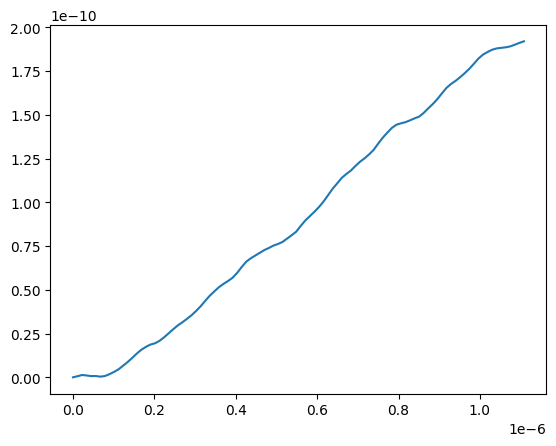

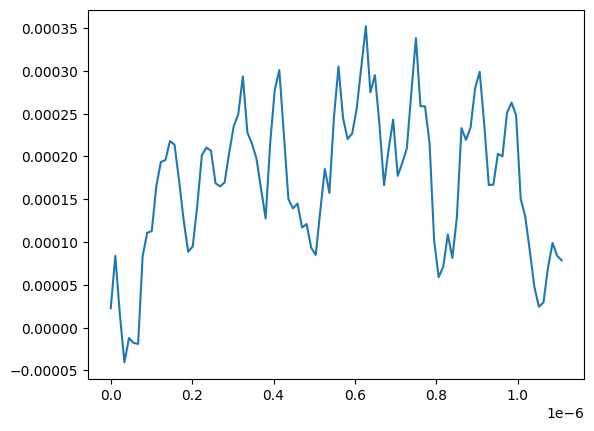

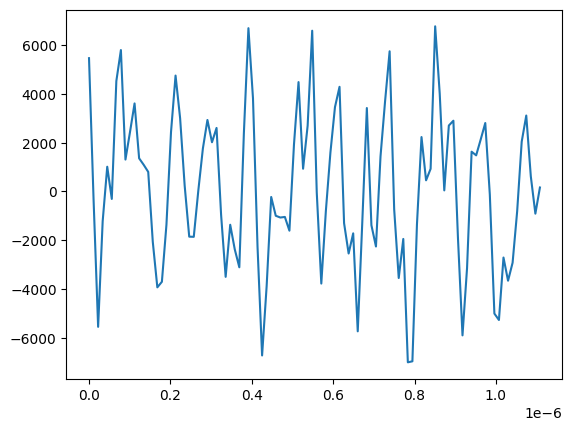

  1%|▏         | 11118/803995 [00:05<06:51, 1928.53it/s]


KeyboardInterrupt: 

In [2]:
# SIMULATIONS

chunksize = 10 ** 6  # Adjust chunk size based on your memory availability
chunks = []

for chunk in pd.read_csv(r'C:\Users\mct2723\Desktop\Repos\MarkovianEmbedding\position_velocity_data.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

# Extract only the columns that start with 'Position' or 'Velocity'
position_cols = [col for col in df.columns if col.startswith('Position')]
velocity_cols = [col for col in df.columns if col.startswith('Velocity')]

timestep_sim = df['real_timestep_s'].values[0]
positions_sim = []
velocities_sim = []
for i in range(len(position_cols)):
    positions_sim.append(df[position_cols[i]].astype(float).values)
    velocities_sim.append(df[velocity_cols[i]].astype(float).values)

# print(f"Positions shape: {positions_sim.shape}")
# print(f"Velocities shape: {velocities_sim.shape}")

bin_num_sim = 20
fs_sim = 1/(timestep_sim * bin_num_sim)

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

def get_acceleration(velocity, dt):
    acceleration = np.zeros_like(velocity)

    # Use forward difference at the first point
    acceleration[0] = (velocity[1] - velocity[0]) / dt

    # Use centered difference for the middle points
    acceleration[1:-1] = (velocity[2:] - velocity[:-2]) / (2 * dt)

    # Use backward difference at the last point
    acceleration[-1] = (velocity[-1] - velocity[-2]) / dt

    return acceleration

def get_basset_force(a_series, start_idx):
    max_tau = start_idx
    lags = np.arange(1, max_tau+1)[::-1]/fs_sim
    basset_integral = []
    for curr_idx in tqdm(range(start_idx, len(a_series))):
        curr_integral = simpson(a_series[curr_idx-max_tau:curr_idx]/np.sqrt(lags), x=lags)
        basset_integral.append(curr_integral)
    return basset_integral

def get_basset_force_fast(a_series, fs_sim, start_idx):
    dt = 1 / fs_sim
    a_series = np.asarray(a_series).flatten()
    n = len(a_series)

    # Simpson's rule requires an odd number of intervals → even number of points
    if start_idx % 2 == 0:
        start_idx += 1  # ensure odd number of samples for Simpson

    # Time kernel
    t_kernel = np.arange(1, start_idx + 1) * dt  # skip t=0
    base_kernel = 1 / np.sqrt(t_kernel)

    # Simpson's weights
    weights = np.ones_like(base_kernel)
    weights[1:-1:2] = 4
    weights[2:-1:2] = 2
    weights *= dt / 3

    # Final kernel: reversed for causal convolution
    simpson_kernel = (base_kernel * weights)[::-1]

    # FFT convolution
    full_basset = fftconvolve(a_series, simpson_kernel, mode='full')[:n]

    return full_basset[start_idx:]

def get_basset_force_fast_old(a_series, fs_sim, start_idx):
    dt = 1 / fs_sim
    n = len(a_series)

    # Create kernel of length start_idx (i.e., full Basset history window)
    t_kernel = np.arange(1, start_idx+1) * dt  # avoids sqrt(0)
    kernel = (1 / np.sqrt(t_kernel))[::-1]
    kernel *= dt  # Riemann sum

    # Convolve using FFT
    full_basset = fftconvolve(a_series, kernel, mode='full')[:n]

    # Trim the output to start only from start_idx
    return full_basset#[start_idx:]


traces_sim = []
for trace in positions_sim:
    series = bin_data(trace, bin_num_sim)
    traces_sim.append(series)

times = np.arange(len(traces_sim[0]))/fs_sim

print("len of traces is " + str(len(traces_sim[0])))

v_traces_sim = []
for trace in velocities_sim:
    series = bin_data(trace, bin_num_sim)
    v_traces_sim.append(series)

a_traces_sim = []
for trace in v_traces_sim:
    series = get_acceleration(trace, times[1]-times[0])
    a_traces_sim.append(series)

plt.plot(times[:100], traces_sim[0][:100])
plt.show()
plt.plot(times[:100], v_traces_sim[0][:100])
plt.show()
plt.plot(times[:100], a_traces_sim[0][:100])
plt.show()

tau_max_idx = int(.001*fs_sim)
bass = get_basset_force(a_traces_sim[0], tau_max_idx)

r_series = []

positions = np.array(traces_sim[0])[tau_max_idx:]
velocities = np.array(v_traces_sim[0])[tau_max_idx:]
accelerations = np.array(a_traces_sim[0])[tau_max_idx:]

# We pick .001 as the max tau (how far back to begin calculating history - as it gives roughly 1% the value of 1/sqrt(1e-7) which is our min tau)
tau_max_idx = int(.001*fs_sim)
r_series = mass*accelerations+gamma*velocities+K*positions+z*np.array(bass)

plt.plot(times[:100], r_series[:100])

In [31]:
# Now Correlate R and V

def cross_correlation(series1, series2, dt):
    if(len(series1) != len(series2)):
        print("series1 has " + str(len(series1)))
        print("series2 has " + str(len(series2)))
        return 0
    n = len(series1)
    cc = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(1, n, 1) * dt  # Calculate lag times

    for tau in tqdm(np.array(range(1, n, 1))):
        cc_tau = series1[tau:]*series2[:n - tau]
        cc[tau] = np.mean(cc_tau)
    cc[0] = 0
    return cc, lag_times

# This is the wrong thing as both are positive time - just to chekc
r_cross_corr_v = cross_correlation(r_series, velocities, 1/fs_sim)

100%|██████████| 803994/803994 [10:06<00:00, 1326.44it/s] 


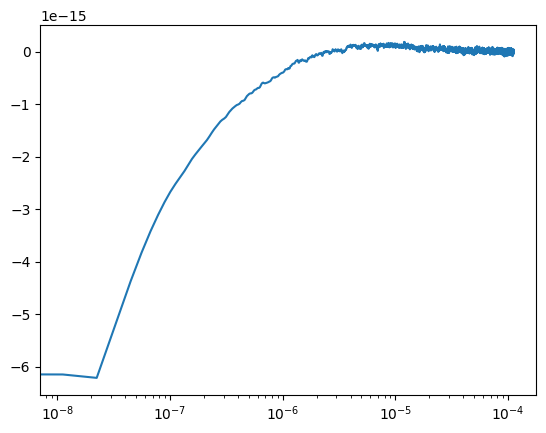

In [32]:
plt.plot(times[:10000], r_cross_corr_v[0][:10000])
plt.xscale("log")

std of data vel 0.0002738038126559451
total idx data: 6391


100%|██████████| 6391/6391 [00:06<00:00, 1058.69it/s]


Finding avg
we summed 6391
-0.23601575192887567
Found avg


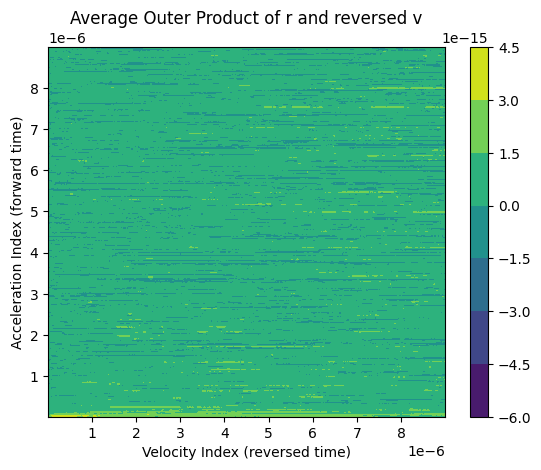

In [33]:
# But we want R(positive times) correlated with v(negative times)
from matplotlib.colors import LogNorm

# First, we condition around zero velocity

speeds = [0]
traces_per_speed = [0]

speeds_msds = []

speed_tol = [.01]

for s in range(len(speeds)):
   
    
    init_len_data = int(len(positions)/1000)

    speed_idxs_data = []
    print("std of data vel " + str(np.std(velocities)))
    
    v_tolerance = (speeds[s] * np.sqrt(constants.k*temp/mass))
    speed_tolerance = speed_tol[s] * np.sqrt(constants.k*temp/mass)
    v_indices_data = np.where((velocities < v_tolerance + speed_tolerance) & (velocities > v_tolerance - speed_tolerance))[0]
    
    for idx in v_indices_data:
        if (idx + init_len_data < len(positions)) and (idx-init_len_data >= 0):
            speed_idxs_data.append(idx)

    print("total idx data: " + str(len(speed_idxs_data)))

    sum_ = np.zeros((init_len_data, init_len_data))
    i = 0
    for idx in tqdm(speed_idxs_data):
        sum_ += (np.outer(r_series[idx:idx+init_len_data], velocities[idx-init_len_data+1:idx+1][::-1]))#[idx:idx+init_len_data]
        i+=1
    
    X = np.arange(1, init_len_data+1)*1/fs_sim
    Y = np.arange(1, init_len_data+1)*1/fs_sim
    print("Finding avg")
    print("we summed " + str(i))
    print(accelerations[1]*velocities[1])
    avg_contour = sum_/i
    print("Found avg")
    plt.contourf(X, Y, avg_contour)
    plt.title("Average Outer Product of r and reversed v")
    plt.colorbar()
    plt.xlabel("Velocity Index (reversed time)")
    plt.ylabel("Acceleration Index (forward time)")
    # plt.xscale("log")
    # plt.yscale("log")
    plt.show()
    #
    # for idx in tqdm(speed_idxs_data):
    #     sum_ += (np.outer(accelerations[idx:idx+init_len_data], velocities[idx:idx+init_len_data]))#[idx:idx+init_len_data]
    #     i+=1
    # X = np.arange(init_len_data)*1/fs_sim
    # Y = np.arange(init_len_data)*1/fs_sim
    # print("Finding avg")
    # avg_contour = sum_/i
    # print("Found avg")
    # plt.contourf(X, Y, avg_contour)
    # plt.title("Average Outer Product of r and v")
    # plt.colorbar()
    # plt.xlabel("Velocity Index (forward time)")
    # plt.ylabel("Acceleration Index (forward time)")
    # # plt.xscale("log")
    # # plt.yscale("log")
    # plt.show()

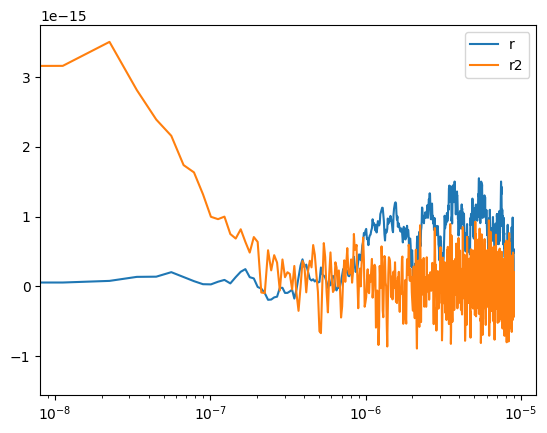

100%|██████████| 50/50 [21:04<00:00, 25.29s/it]


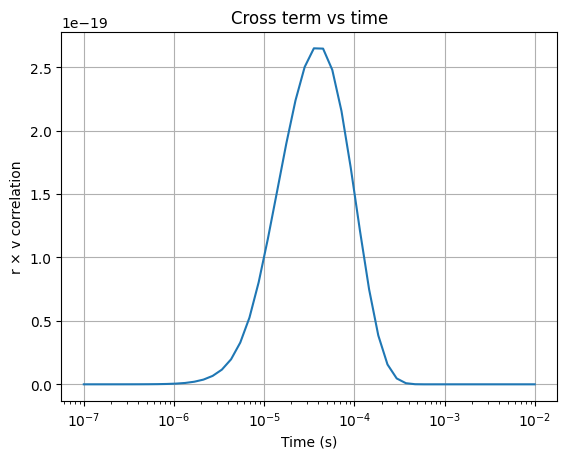

In [34]:
# What we really want to calculate is z*int(g(tau, s')*<R(s)v(tau)>dtau)
from mpmath import mp, invertlaplace, mpc, mpf, sqrt, pi, exp, erfc
import math

mp.dps = 30

def b_inverse_form(t, roots):
    return np.real((1/mass) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

roots = compute_roots(mass, K, r, eta, rho_f)

# History term in Laplace domain - see overlead doc
def gB(s, tau):
    s = mpc(s)
    tau = mpf(tau)
    D = mass*(roots[0] + sqrt(s)) * (roots[1] + sqrt(s)) * (roots[2] + sqrt(s)) * (roots[3] + sqrt(s))
    inv = 1/sqrt(-tau) - 1 * exp(-tau*s) * sqrt(s) * sqrt(pi) * erfc(sqrt(-tau*s))
    return inv / D

# Inverse Laplace transform F^-1[f(s, tau)] -> f(t, tau)
def f(t, tau):
    def gB_s(s):
        return gB(s, tau) # Calls the actual function
    return float(mp.re(invertlaplace(gB_s, t, method='talbot')))

# lets implement the slide that involves the  correlation function

# <r v>
r_v = avg_contour

# how to acces r_v slice at tau (vel = tau')............r_v[tau_time]???????????? no
plt.plot(np.arange(init_len_data)*1/fs_sim, r_v[20, :], label="r") # Wrong
plt.plot(np.arange(init_len_data)*1/fs_sim, r_v[:, 20], label="r2") # Correct
plt.xscale("log")
plt.legend()
plt.show()

# inner intergral over t' # Need to loop this over taus
def inner_int_as_func_tau(t_2, tau):
    ret = []
    t_prime_full = np.arange(1, init_len_data+1)*1/fs_sim
    t_prime = t_prime_full[t_prime_full <= t_2]
    for tau_time in tau:
        integrand = np.array(r_v[:,int(tau_time*fs_sim)][:len(t_prime)])*np.array(b_inverse_form(t_2 - np.array(t_prime), roots))
        total = simpson(integrand, t_prime)
        ret.append(total)
    return np.array(ret)

def outer_int(t_1, t_2):
    # tau is supppose to go from -inf to zero, we need it to match the contour
    taus = -np.arange(1, init_len_data+1)*1/fs_sim
    prod1 = []
    for tau in taus:
        prod1.append(f(t_1, tau))
    integrand = np.array(prod1)*inner_int_as_func_tau(t_2, taus)
    total = simpson(integrand, taus)
    return total

def get_r_cross_term(t_1, t_2):
    z = 6*r**2*np.sqrt(np.pi*eta*rho_f)
    r_cross_v_term = (z * outer_int(t_1, t_2))
    return -1 * r_cross_v_term


plot_times = np.logspace(-7, -2, 50)
results = [get_r_cross_term(t, t) for t in tqdm(plot_times)]

plt.plot(plot_times, results)
plt.xscale("log")
plt.xlabel("Time (s)")
plt.ylabel("r × v correlation")
plt.title("Cross term vs time")
plt.grid(True)
plt.show()


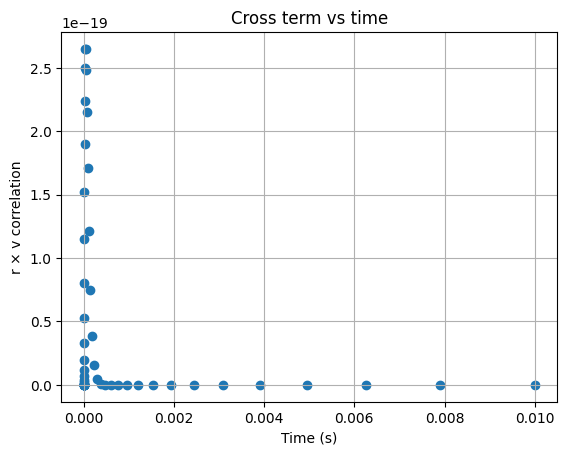

In [35]:

plt.scatter(plot_times, results)
# plt.xscale("log")
plt.xlabel("Time (s)")
plt.ylabel("r × v correlation")
plt.title("Cross term vs time")
plt.grid(True)
plt.show()

In [37]:
import numpy as np

# Assuming plot_times and results are numpy arrays or lists
data = np.column_stack((plot_times, results))

# Save to a text file
np.savetxt(r"C:\Users\Cole Thumann\Downloads\r_v_cross_correlation.txt", data, header="time(s)\tresult", fmt="%.8e", delimiter="\t")
